In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot convergence for IMEX-RB on 2D nonlinear problem
We study convergence on the 2D viscous Burgers equation

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = "Burgers2D"
test_name = "convergence"
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

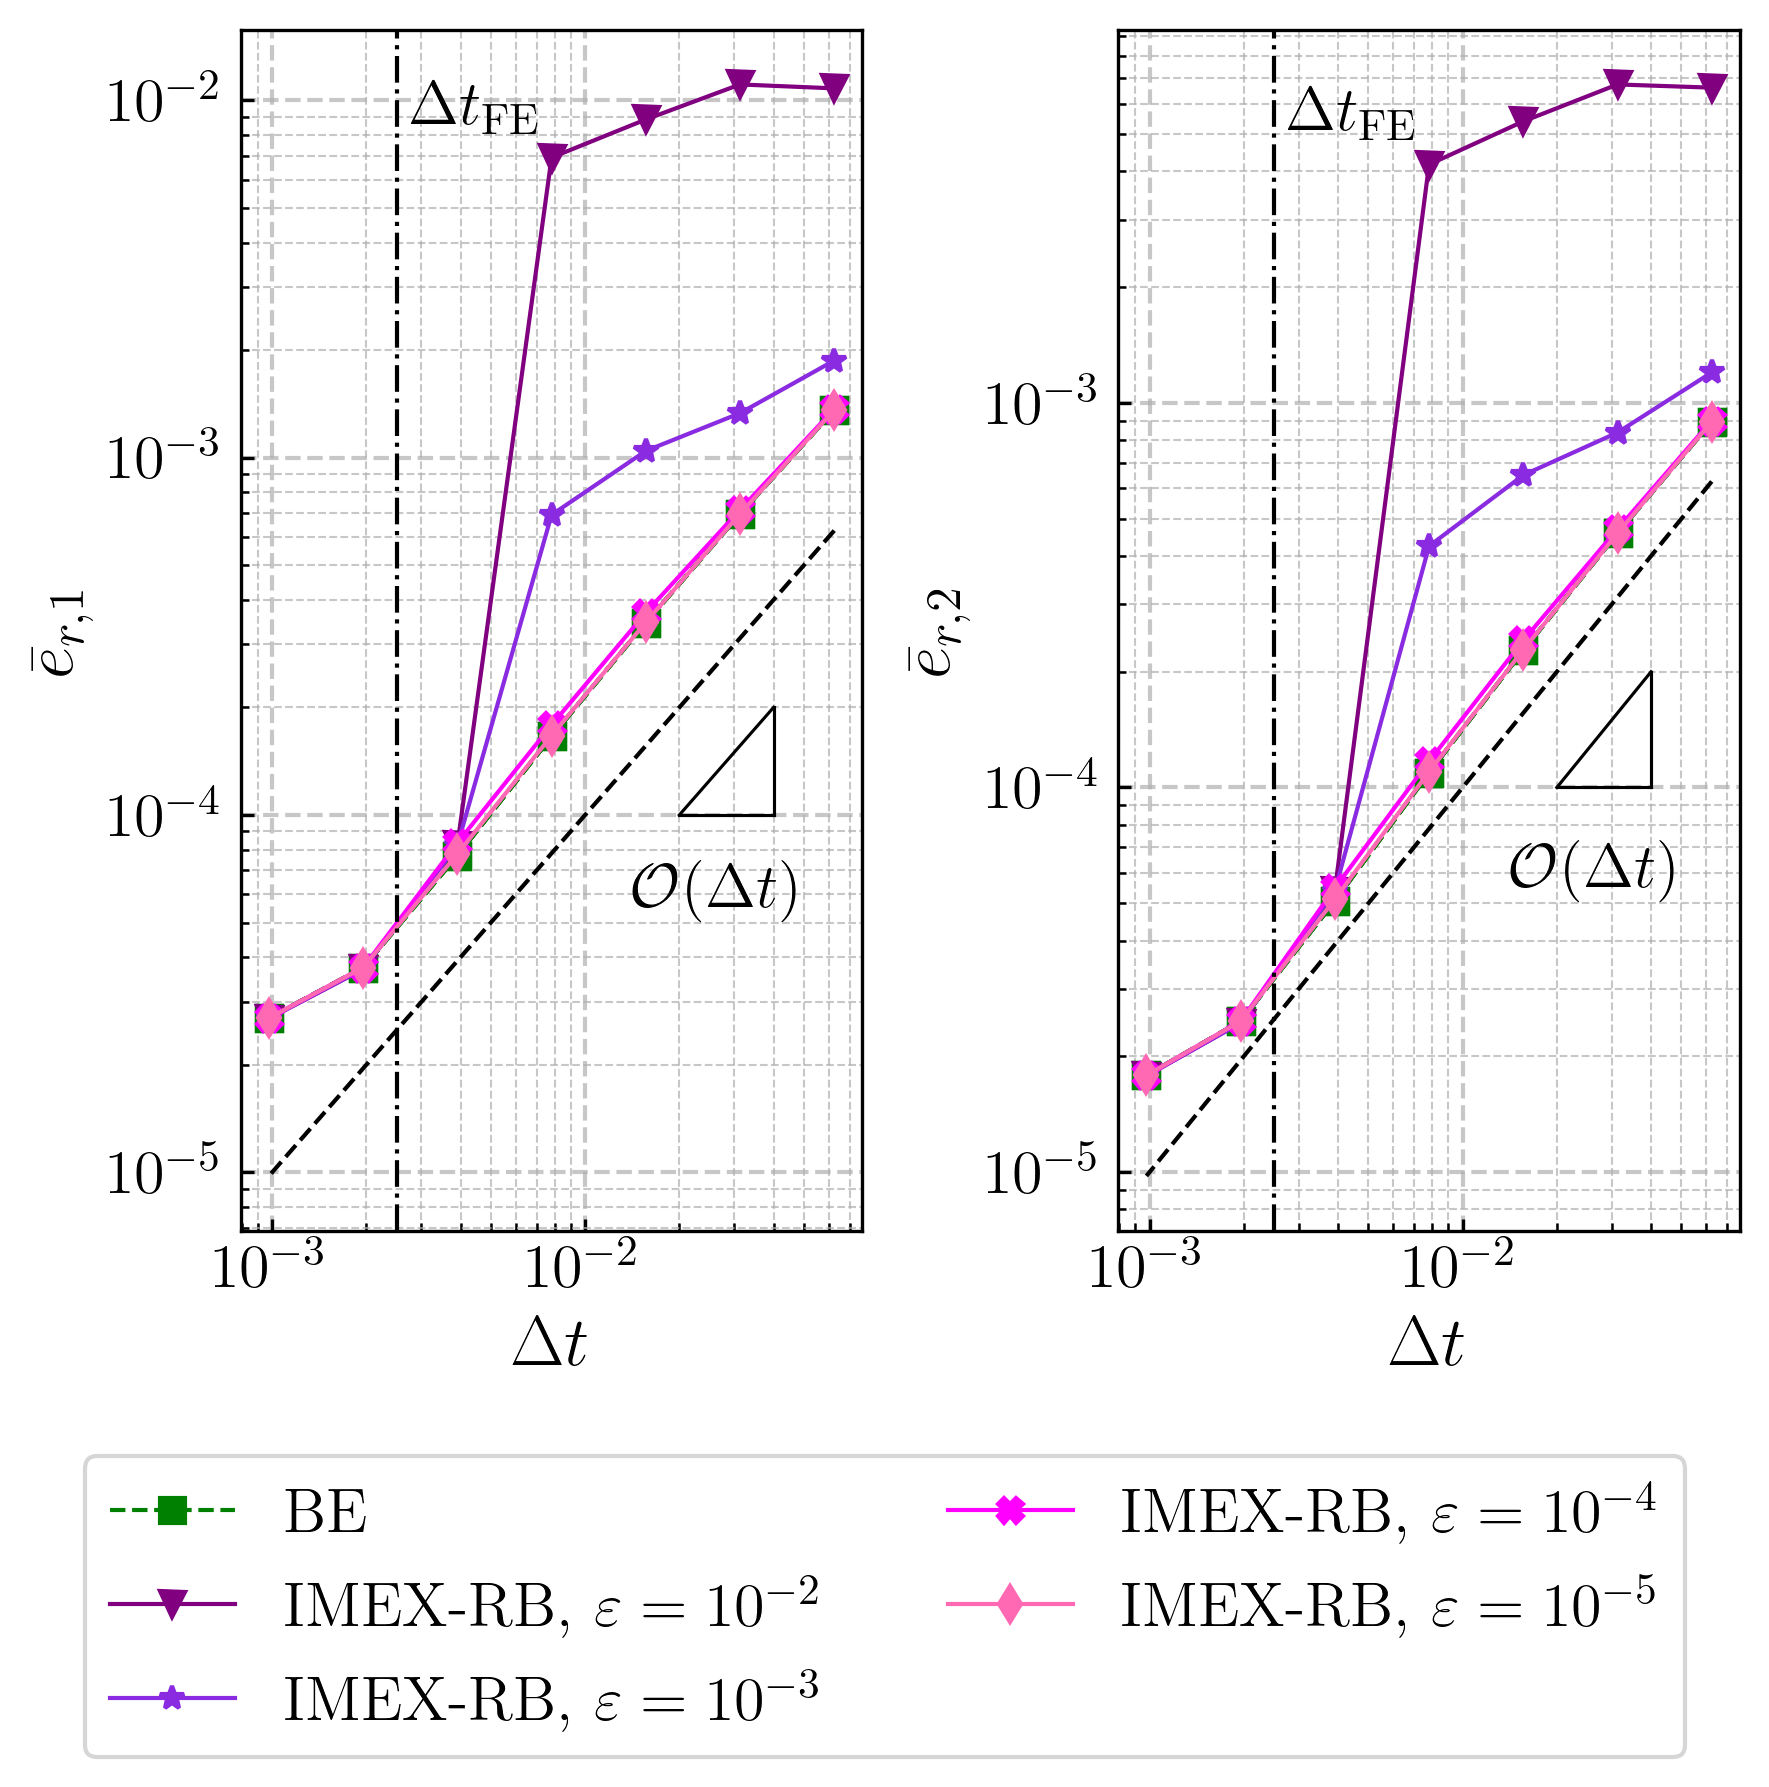

In [6]:
plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_l2 = data['errors_l2'].item()
Nt_values = data['Nt_values']
epsilon_values = data['epsilon_values']
NtFE = 400

dts = 1.0 / Nt_values

all_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
all_colors = [
    'purple', 'blueviolet', 'magenta', 'hotpink',
    'red', 'maroon', 'teal', 'orange'
]
larger_fontsize = 17
smaller_fontsize = 15

fig, axes = plt.subplots(1, 2, figsize=(6, 4.8))

legend_elements = []
legend_labels = []

for comp in range(errors_l2['BE'].shape[0]):
    ax = axes[comp]

    errs_be = errors_l2['BE'][comp]
    line_be = ax.loglog(dts, errs_be, marker='s', markersize=6,
              color='green', linestyle='--')
    
    #add to legend on first component
    if comp == 0:
        legend_elements.append(line_be[0])
        legend_labels.append('BE')

    for ie, eps in enumerate(epsilon_values):
        errs_imex = errors_l2['IMEX-RB'][comp, :, ie]
        expnt = int(np.log10(eps))
        label_imex = rf'IMEX-RB, $\varepsilon = 10^{{{expnt}}}$'
        
        line_imex = ax.loglog(
            dts,
            errs_imex,
            marker=all_markers[ie],
            markersize=6,
            color=all_colors[ie],
            linestyle='-'
        )
        
        # add to legend on first component
        if comp == 0:
            legend_elements.append(line_imex[0])
            legend_labels.append(label_imex)

    ax.loglog(
        dts,
        [dt / 100.0 for dt in dts],
        color='k',
        linestyle='--',
    )

    ax.axvline(1 / NtFE, color='k', linestyle='-.')
    ax.text(
        1 / NtFE * 1.1,
        ax.get_ylim()[1] * 0.6,
        rf'$\Delta t_{{\mathrm{{FE}}}}$',
        rotation=0,
        verticalalignment='center',
        color='k',
        fontsize=smaller_fontsize
    )

    # reference slope triangle
    x0, y0 = 0.02, 0.0001
    dx = 0.02
    dy = y0 * ((x0+dx) / x0) - y0
    ax.plot([x0, x0 + dx], [y0, y0], 'k-', linewidth=0.75)
    ax.plot([x0 + dx, x0 + dx], [y0, y0 + dy], 'k-', linewidth=0.75)
    ax.plot([x0 + dx, x0], [y0 + dy, y0], 'k-', linewidth=0.75)
    ax.text(
        5e-2,
        5e-5,
        r"$\mathcal{O}(\Delta t)$",
        fontsize=smaller_fontsize,
        ha='right',
        va='bottom'
    )

    ax.grid(which='major', linestyle='--', linewidth=1)
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
    ax.set_xlabel(r'$\Delta t$', fontsize=larger_fontsize)
    ax.set_ylabel(rf'$\bar{{e}}_{{r,{comp+1}}}$', fontsize=larger_fontsize)

# unique elements
fig.legend(
    legend_elements,
    legend_labels,
    bbox_to_anchor=(0.5, -0.0),
    loc='upper center',
    ncol=2,
    fontsize=smaller_fontsize
)

plt.tight_layout()
out_file = os.path.join(
    plots_dir, f'{problem_name}_convergence_combined.pdf'
)
plt.savefig(out_file, bbox_inches='tight', dpi=400)
plt.show()
plt.close()